In [3]:
import torch
import os
import cv2
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.io import read_image
import random
import matplotlib.pyplot as plt

from model_autoencoder import Autoencoder
from model_CNN_MlpClassifier import Classifier
from torchvision import models
from dataset import ImagesDataset
from utils import plot_losses

from config import *

In [24]:
model_to_train = "our_classifier"

metadata = pd.read_csv(METADATA_FILE)
window_metadata = pd.read_csv(WINDOW_METADATA_FILE)

directories = [dir.path for dir in os.scandir(ANNOTATED_PATCHES_DIR) if dir.is_dir()]

# Define transformations and data loaders for training and testing
train_transform = transforms.Compose([
    transforms.Resize((128, 128), antialias=True),
    #transforms.RandomHorizontalFlip(p=0.5),  
    #transforms.RandomVerticalFlip(p=0.5),  
    #transforms.RandomPerspective(distortion_scale=0.5, p=0.2),  # Adjust distortion_scale as needed
    #transforms.RandomRotation(degrees=(0, 15)),  # Rotate in all angles
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Adjust mean and std as needed
])

test_transform = transforms.Compose([
    transforms.Resize((128, 128), antialias=True),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Adjust mean and std as needed
])

metadata = pd.read_csv(WINDOW_METADATA_FILE)
targets = []
files = []
metadata[['IDPacient','IDWindow']] = metadata['ID'].str.split('.', n=1, expand=True)
for d in os.listdir(ANNOTATED_PATCHES_DIR):
    if d in list(metadata['IDPacient']):
        for p in os.listdir(ANNOTATED_PATCHES_DIR+'/'+d):
            try:
                id = d+'.'+p[:-4]
                target = int(window_metadata[window_metadata['ID'] == id]['Presence'])
                if target == -1:
                    targets.append(0)
                    files.append(d+'/'+p)
                elif target == 1:
                    targets.append(1)
                    files.append(d+'/'+p)
            except:
                continue

"""combined = list(zip(files, targets))

# Shuffle the combined list
random.shuffle(combined)

# Extract the shuffled lists
files, targets = zip(*combined)"""
data = files[:int(len(files)*0.8)]
targets_train = targets[:int(len(files)*0.8)]
train_dataset = ImagesDataset(data=data, targets=targets_train, data_dir=ANNOTATED_PATCHES_DIR, transform=train_transform)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

data = files[int(len(files)*0.8):]
targets_test = targets[int(len(files)*0.8):]
test_dataset = ImagesDataset(data=data, targets=targets_test, data_dir=ANNOTATED_PATCHES_DIR, transform=test_transform)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)  # No need to shuffle for testing

In [16]:
metadata.head()

,ID,Presence,IDPacient,IDWindow
0,B22-101_0.00180,-1,B22-101_0,00180
1,B22-101_0.00201,1,B22-101_0,00201
2,B22-101_0.00280,-1,B22-101_0,00280
3,B22-101_0.00415,-1,B22-101_0,00415
4,B22-102_0.01468,1,B22-102_0,01468


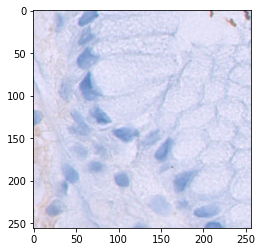

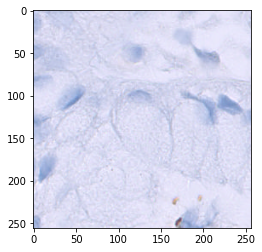

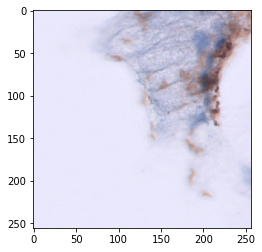

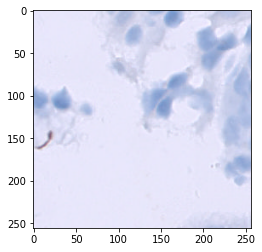

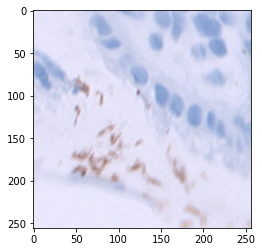

In [21]:
for i in range(10):
    if window_metadata.loc[i,"Presence"] == 1:
        file = ANNOTATED_PATCHES_DIR+window_metadata.loc[i, "ID"]+'.png'
        file = file.replace(".", "/", 1)
        img = cv2.imread(file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
        print(file)
        plt.imshow(img)
        plt.show()


1


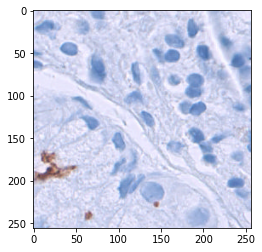

1


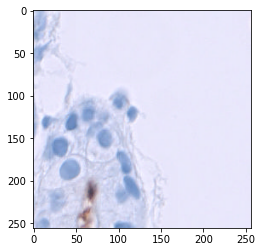

1


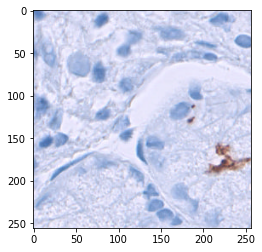

1


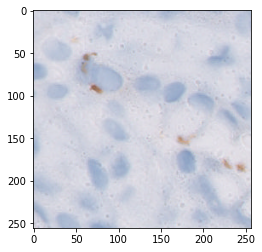

1


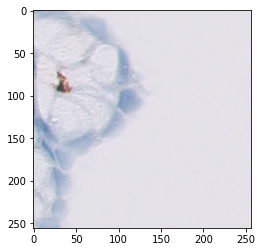

1


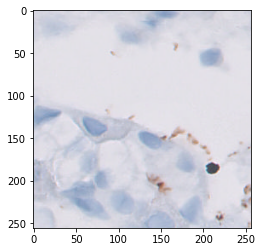

1


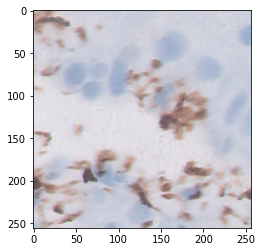

1


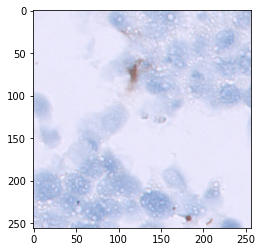

1


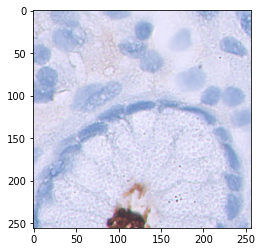

1


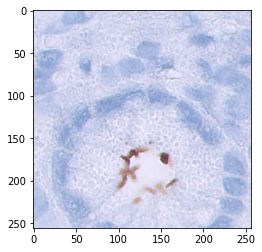

1


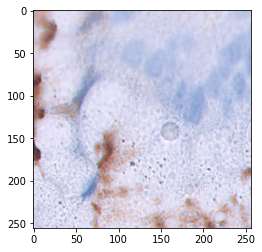

1


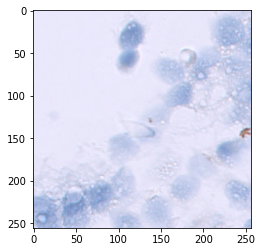

1


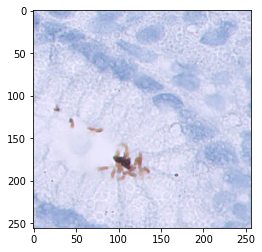

1


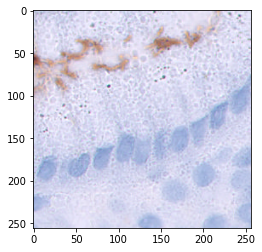

1


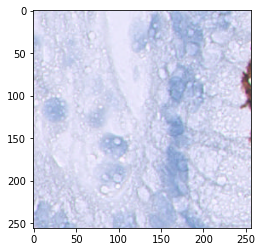

1


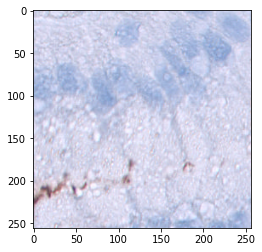

1


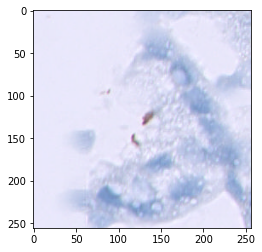

1


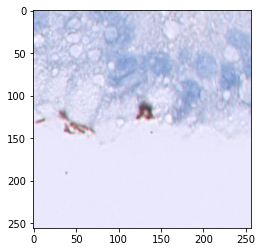

1


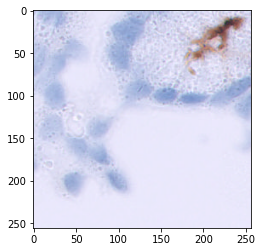

1


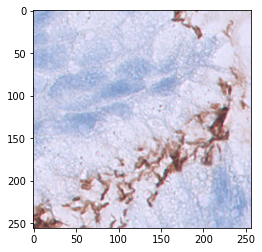

1


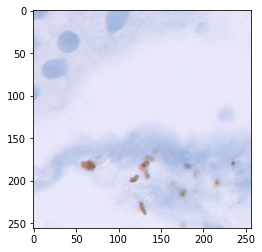

1


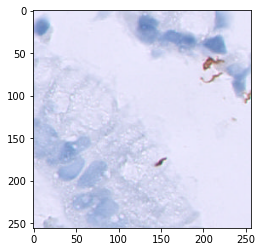

1


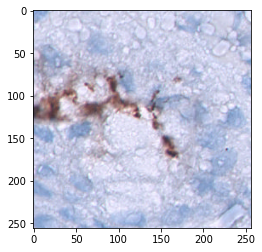

1


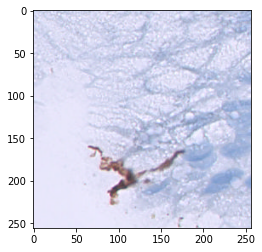

1


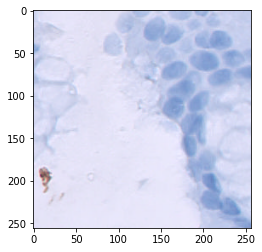

1


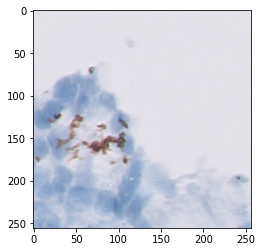

1


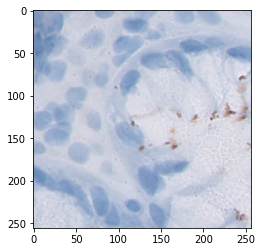

1


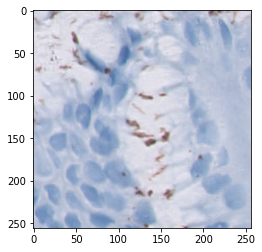

1


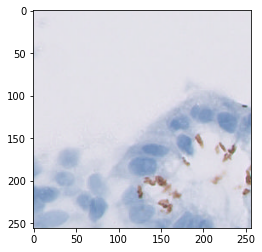

1


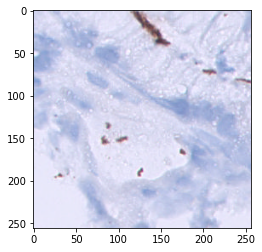

In [25]:
for file, target in zip(files[200:400], targets[200:400]):
    if target == 1:
        img = cv2.imread(ANNOTATED_PATCHES_DIR+file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
        print(target)
        plt.imshow(img)
        plt.show()

In [28]:
model = Autoencoder()
model.load_state_dict(torch.load("/fhome/mapsiv01/PSIV3_malaltia/autoencoder/models/model5_AUTOENCODER.pth", map_location=torch.device('cpu')))

metadata = pd.read_csv(METADATA_FILE)
window_metadata = pd.read_csv(WINDOW_METADATA_FILE)
directories = [dir.path for dir in os.scandir(ANNOTATED_PATCHES_DIR) if dir.is_dir()]

In [29]:
transform = transforms.Compose([
    transforms.Resize((64, 64), antialias=True),
    transforms.Normalize(mean=[0.5], std=[0.5])])

transform_un = transforms.Compose([
    transforms.Normalize(mean=[-0.5/0.5], std=[1/0.5])])

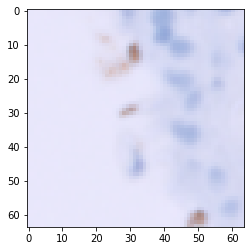

True

In [76]:
im = read_img('00045.png', '/fhome/mapsiv/QuironHelico/AnnotatedPatches/B22-37_0')
im= transform_un(im)
im = im.permute(1, 2, 0).detach().numpy()
im= (im * 255).astype(np.uint8)
plt.imshow(im)
plt.show() 
cv2.imwrite(f"/fhome/mapsiv01/PSIV3_malaltia/autoencoder/entrada_autoe.jpg", cv2.cvtColor(im, cv2.COLOR_BGR2RGB))

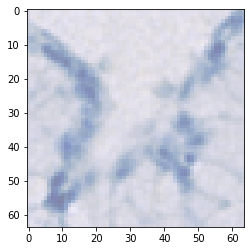

True

In [65]:
def read_img(file, dir):
    img = read_image(os.path.join(dir, file))[:-1,:,:]
    img = img.to(torch.float32)
    img = img/255
    img = transform(img)
    return img
img = read_img('00049.png', '/fhome/mapsiv/QuironHelico/CroppedPatches/B22-189_1')
model.eval()
im_processed = model(img, "autoencoder")
im_processed = transform_un(im_processed)
im_processed = im_processed.permute(1, 2, 0).detach().numpy()
im_processed = (im_processed * 255).astype(np.uint8)

plt.figure()
plt.imshow(im_processed)
plt.show()
cv2.imwrite(f"/fhome/mapsiv01/PSIV3_malaltia/autoencoder/sortida_autoe.jpg", cv2.cvtColor(im_processed, cv2.COLOR_BGR2RGB))